In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from scipy import fftpack
import nbformat
import plotly.graph_objects as go
from PIL import Image
from turbustat.statistics import PowerSpectrum
from scipy.signal import butter, filtfilt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [7]:
# File containing the images
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_10kHz_1_MMStack_Pos0.ome.tif")

immagini = tifffile.imread(file) 

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
plate_scale = 0.0377 #0.0244*2 #0.0376*2 #0.0268 marzo #0.0244 febb #0.0376 #

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 700e-9                                                 # Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds, diffraction_limit_arcseconds/plate_scale)
print("Prima :", diffraction_limit_arcseconds/0.0376)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds/plate_scale) # corrisponde al diametro del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)



Diffraction limit in arcseconds and pixels:  0.19357176923076921 5.134529687818812
Prima : 5.14818535188216
Check radius in pixels:  5


### Immagine prova

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\buonc\AppData\Local\Temp\ipykernel_21304\1429857575.py:1: SyntaxWarning: invalid escape sequence '\p'
  image = np.asarray(Image.open('immagini\prova_fft.png'))


(1127, 2002)


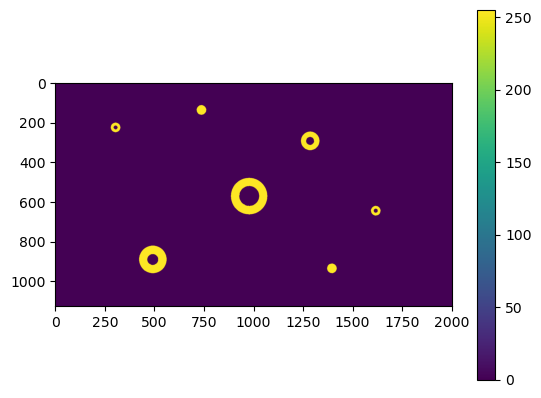

In [4]:
image = np.asarray(Image.open('immagini\prova_fft.png'))
print (image.shape)
imgplot = plt.imshow(image)
plt.colorbar(imgplot, orientation='vertical')

## Power spectrum 1

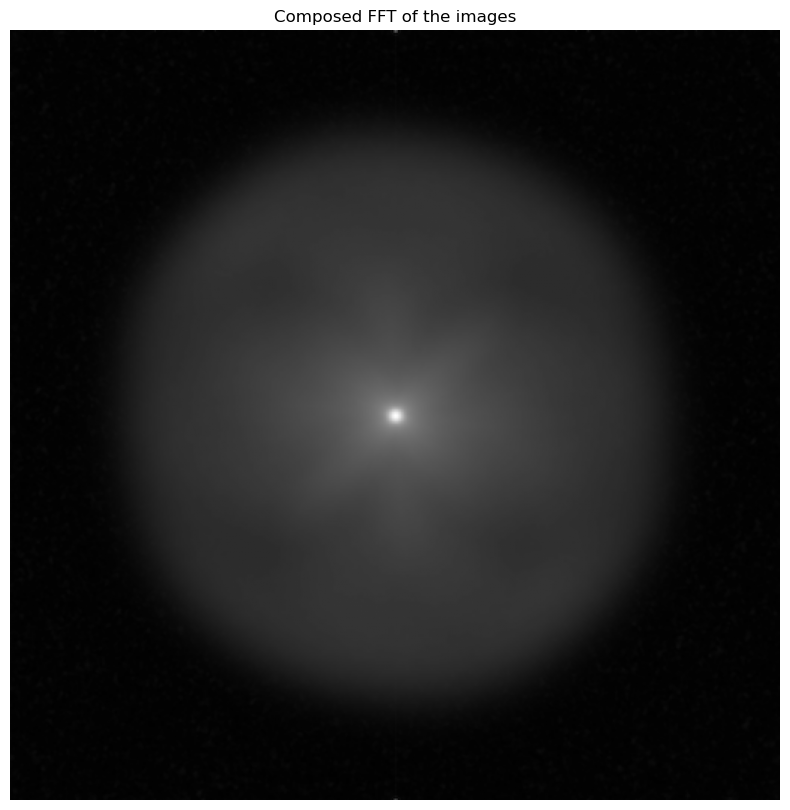

In [20]:
sum_ft = 0

for i in range(4999):
    imagenumber = 0 + i 
    data = immagini[imagenumber]

    data_raw = data.copy()
    data_clean = data_raw.copy()
    background_level = np.median(data_raw)
    data = data_raw - background_level
    data[data < 0] = 0

    image = data.copy()
    if image.ndim == 3:
        image = image[:, :, :3].mean(axis=2) 
    elif image.ndim == 2:
        image = image  
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.shape))

    ft = calculate_2dft(image)
    sum_ft += np.abs(ft)


plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(np.log(sum_ft))
plt.axis("off")
plt.title("Composed FFT of the images")
plt.show()

hdu = fits.PrimaryHDU(sum_ft)
hdul = fits.HDUList([hdu])
hdul.writeto('outputs/composed_fft.fits', overwrite=True)


# Butterworth filter

In [12]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt

# --------------------------------------------
# Butterworth High-Pass Filter
def butterworth_highpass_filter(image, cutoff, order):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - ccol)**2 + (y - crow)**2)

    # Butterworth high-pass mask
    butterworth_hp = 1 / (1 + (cutoff / (distance + 1e-6))**(2 * order))  # Avoid div by zero

    F_image = fft2(image)
    F_filtered = F_image * fftshift(butterworth_hp)
    filtered_image = np.real(ifft2(F_filtered))

    return filtered_image, butterworth_hp

# --------------------------------------------
imagenumber = 500
stacked = False  # Set to True to stack images

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# --------------------------------------------
# Apply Butterworth High-Pass Filter
cutoff = 10    # Radius in pixels
order = 9      # Filter sharpness (higher = steeper transition)
highpass, hp_filter = butterworth_highpass_filter(image, cutoff=cutoff, order=order)

# Clean filtered image
highpass = np.nan_to_num(np.maximum(highpass, 0))

# --------------------------------------------
# Power Spectrum Calculation
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# --------------------------------------------
# Plot Power Spectra
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'Butterworth High-Pass (cutoff={cutoff}, order={order})', alpha=0.9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# --------------------------------------------
# Plot Filter
plt.figure(figsize=(6, 5))
plt.imshow(hp_filter, cmap='gray')
plt.title("Butterworth High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2D Fourier Transform Plot
def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image)
    F_image_shifted = fftshift(F_image)
    magnitude = np.abs(F_image_shifted)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D FFT")
plot_fourier_transform(highpass, title="High-Pass Filtered Image: 2D FFT")

#output_path = "outputs/highpass_filtered_image_Butterworth_filter.fits"
#fits.writeto(output_path, highpass, overwrite=True)
#print(f"Highpass filtered image saved to {output_path}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=custom_cmap)
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(highpass, cmap=custom_cmap)
plt.title("Filtered Image")
plt.colorbar()
plt.tight_layout()
plt.show()

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:195: SyntaxWarning: invalid escape sequence '\p'
  """


KeyboardInterrupt: 

# Butterworth Passband 2

In [11]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt

# --------------------------------------------
# Butterworth High-Pass Filter
def butterworth_bandpasspass_filter(image, cutoff_low, cutoff_high, order):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - ccol)**2 + (y - crow)**2)

    # bandpass mask
    butterworth_hp = 1 / (1 + (cutoff_low / (distance + 1e-6))**(2 * order))  # Avoid div by zero
    butterworth_lp = 1 / (1 + (distance / (cutoff_high + 1e-6))**(2 * order))  # Avoid div by zero

    bandpass_filter = butterworth_hp * butterworth_lp
    
    F_image = fft2(image)
    F_filtered = F_image * fftshift(bandpass_filter)
    filtered_image = np.real(ifft2(F_filtered))

    return filtered_image, bandpass_filter

# --------------------------------------------
imagenumber = 500
stacked = False  # Set to True to stack images

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# --------------------------------------------
# Apply Butterworth High-Pass Filter
cutoff = 10    # Radius in pixels
order = 9      # Filter sharpness (higher = steeper transition)
highpass, hp_filter = butterworth_highpass_filter(image, cutoff=cutoff, order=order)

# Clean filtered image
highpass = np.nan_to_num(np.maximum(highpass, 0))

# --------------------------------------------
# Power Spectrum Calculation
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# --------------------------------------------
# Plot Power Spectra
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'Butterworth High-Pass (cutoff={cutoff}, order={order})', alpha=0.9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# --------------------------------------------
# Plot Filter
plt.figure(figsize=(6, 5))
plt.imshow(hp_filter, cmap='gray')
plt.title("Butterworth High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2D Fourier Transform Plot
def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image)
    F_image_shifted = fftshift(F_image)
    magnitude = np.abs(F_image_shifted)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D FFT")
plot_fourier_transform(highpass, title="High-Pass Filtered Image: 2D FFT")

#output_path = "outputs/highpass_filtered_image_Butterworth_filter.fits"
#fits.writeto(output_path, highpass, overwrite=True)
#print(f"Highpass filtered image saved to {output_path}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=custom_cmap)
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(highpass, cmap=custom_cmap)
plt.title("Filtered Image")
plt.colorbar()
plt.tight_layout()
plt.show()

NameError: name 'butterworth_highpass_filter' is not defined

# Bandpass scipy.butter

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nan

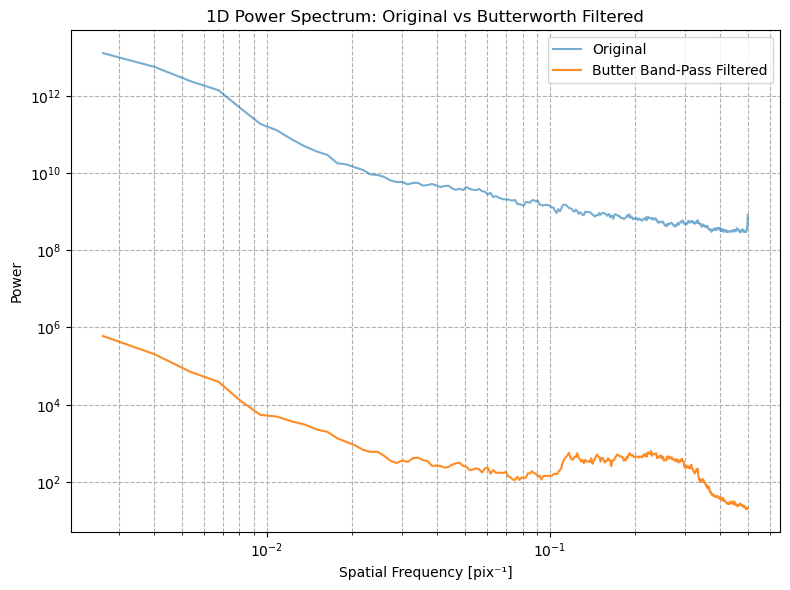

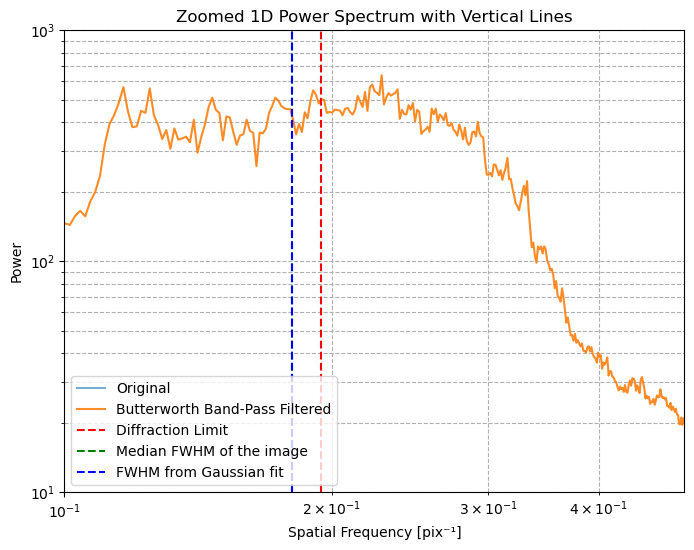

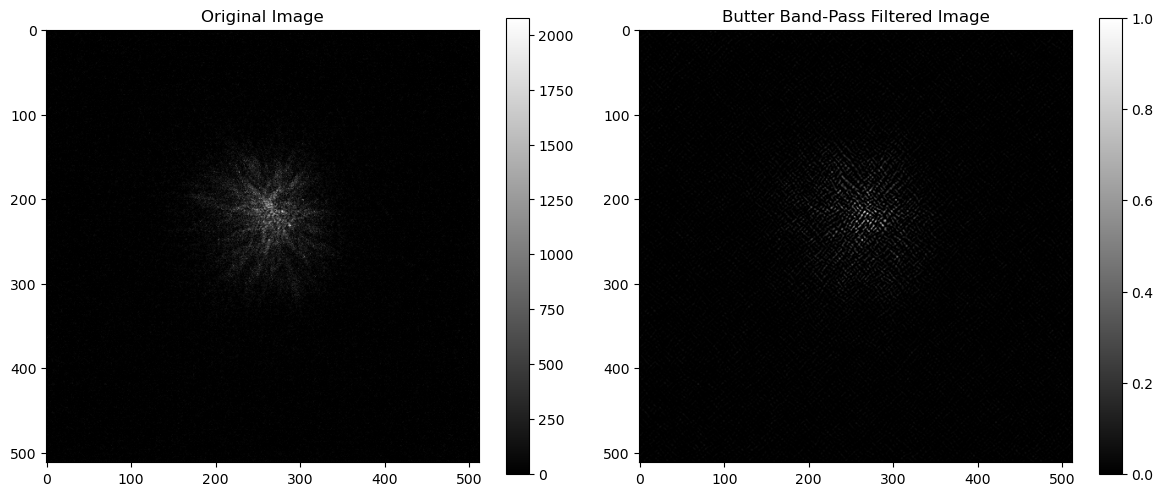

In [15]:

header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0


# Define butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs=1.0, order=4):
    nyq = 0.5 * fs  #0.5 * fs  era prima
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_2d(image, lowcut, highcut, fs=1.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.apply_along_axis(lambda m: filtfilt(b, a, m, method='gust'), axis=1, arr=image)
    filtered = np.apply_along_axis(lambda m: filtfilt(b, a, m, method='gust'), axis=0, arr=filtered)
    return filtered

######################################
imagenumber = 500
stacked = False

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

########################################################
# Set band-pass filter parameters (keep small-scale features)
lowcut = 0.07    # normalized frequency (0 to 1) TOGLIE LE FREQUENZE SOTTO A QUELLA (GRANDI STRUTTURE)
highcut = 0.27                                   #  TOGLIE LE FREQUENZE SOPRA A QUELLA  (STRUTTURE PICCOLE)
order = 9                                       # QUELLO CHE RIMANE SONO LE FREQUENZE TRA QUELLE DUE (normalizzate con nyquist)

filtered_image = apply_bandpass_2d(image, lowcut, highcut, fs=1.0, order=order)

# Clean and normalize
filtered_image = np.nan_to_num(filtered_image, nan=0.0, posinf=0.0, neginf=0.0)
filtered_image[filtered_image < 0] = 0
filtered_image /= (np.max(filtered_image) + 1e-8)


# Compute power spectra
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(filtered_image, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# original vs filtered power spectrum
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.6)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Butter Band-Pass Filtered', alpha=0.9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs Butterworth Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# Zoomed-in plot with vertical lines
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.6)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Butterworth Band-Pass Filtered', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.209/plate_scale), color='g', linestyle='--', label='Median FWHM of the image')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='FWHM from Gaussian fit ')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, pspec_raw.freqs.value.max())
plt.ylim(1e1, 1e3)
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("Zoomed 1D Power Spectrum with Vertical Lines")
plt.legend()
plt.grid(True, which='both', linestyle='--')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("Butter Band-Pass Filtered Image")
plt.colorbar()

plt.tight_layout()
plt.show()



In [6]:

import warnings
warnings.filterwarnings('ignore', category=UserWarning) 
warnings.filterwarnings('ignore', category=RuntimeWarning) 


def butter_bandpass(lowcut, highcut, fs=1.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_2d(image, lowcut, highcut, fs=1.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.apply_along_axis(lambda m: filtfilt(b, a, m, method='gust'), axis=1, arr=image)
    filtered = np.apply_along_axis(lambda m: filtfilt(b, a, m, method='gust'), axis=0, arr=filtered)
    return filtered


imagenumber = 500
stacked = False
if stacked:
    image = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    image = immagini[imagenumber]

background_level = np.median(image)
image = image - background_level
image[image < 0] = 0
image = np.nan_to_num(image)


def update_plot(lowcut=0.05, highcut=0.25, order=4):
    if lowcut >= highcut:
        print("Lowcut must be less than Highcut.")
        return

    filtered = apply_bandpass_2d(image, lowcut, highcut, order=order)
    filtered = np.nan_to_num(filtered)
    filtered[filtered < 0] = 0
    filtered /= (np.max(filtered) + 1e-8)


    header = Header()
    header['CDELT1'] = 1.0
    header['CDELT2'] = 1.0

    pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
    pspec_raw.run(verbose=False, xunit=u.pix**-1)

    pspec_filtered = PowerSpectrum(filtered, header=header, distance=1 * u.pc)
    pspec_filtered.run(verbose=False, xunit=u.pix**-1)

    # Plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title(f"Filtered\nLowcut: {lowcut:.2f}, Highcut: {highcut:.2f}")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label="Original", alpha=0.6)
    plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label="Filtered", alpha=0.8)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Spatial Frequency [pix⁻¹]")
    plt.ylabel("Power")
    plt.title("Power Spectrum")
    plt.grid(True, which='both', linestyle='--')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Create interactive controls
lowcut_slider = widgets.FloatSlider(value=0.05, min=0.01, max=0.49, step=0.01, description='Lowcut:')
highcut_slider = widgets.FloatSlider(value=0.25, min=0.02, max=0.5, step=0.01, description='Highcut:')
order_slider = widgets.IntSlider(value=4, min=1, max=10, step=1, description='Order:')

ui = widgets.VBox([lowcut_slider, highcut_slider, order_slider])
out = widgets.interactive_output(update_plot, {
    'lowcut': lowcut_slider,
    'highcut': highcut_slider,
    'order': order_slider
})

display(ui, out)


Output()

# <span style="color:red; font-size: 1em;">################ PARTI INUTILIZZATE ####################</span>

## Power spectrum

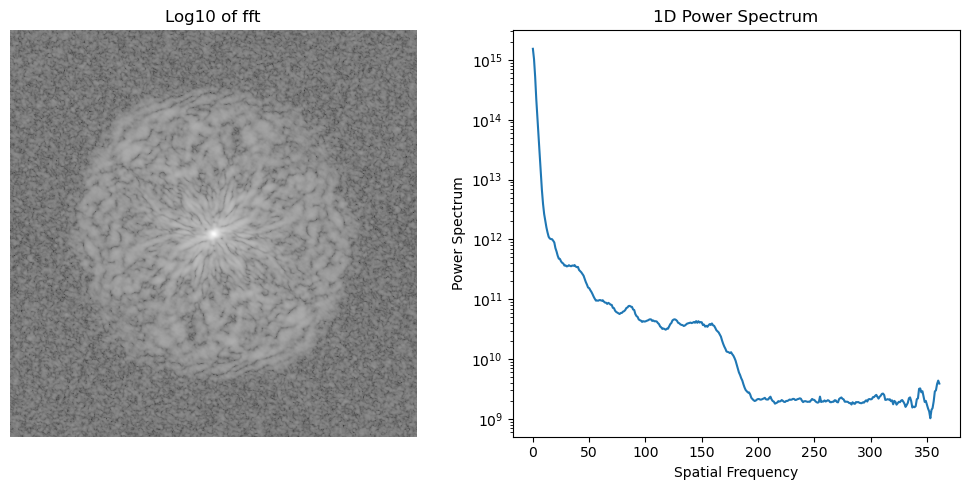

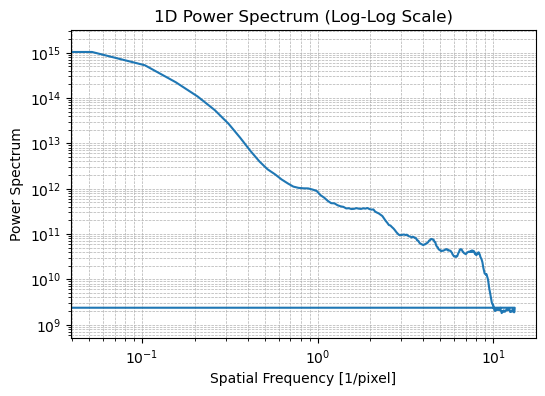

In [ ]:


imagenumber = 500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0

image = data.copy()
#image = image[:1022, :1022]
# Define a function for azimuthal averaging
def azimuthalAverage(image, center=None):
	"""
	Calculate the azimuthally averaged radial profile.

	Parameters:
	-----------
	image : 2D numpy array
		The 2D image
	center : tuple of int, optional
		The (x, y) pixel coordinates used as the center. If None, the center of the image is used.

	Returns:
	--------
	radial_prof : 1D numpy array
		The azimuthally averaged radial profile
	"""
	y, x = np.indices(image.shape)
	if center is None:
		center = (x.max() / 2, y.max() / 2)

	r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
	r = r.astype(int)

	tbin = np.bincount(r.ravel(), image.ravel())
	nr = np.bincount(r.ravel())
	radial_prof = tbin / nr
	return radial_prof

# Use the azimuthalAverage function instead of radialProfile.azimuthalAverage

F1 = fftpack.fft2(image)
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift( F1 )

# 2D power spectrum
psd2D = np.abs( F2 )**2

#azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(psd2D)

# Plot the 2D power spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(psd2D), cmap='gray')
plt.title("Log10 of fft")
plt.axis("off")

# Plot the azimuthally averaged 1D power spectrum
plt.subplot(1, 2, 2)
plt.semilogy(psd1D)
plt.title("1D Power Spectrum")
plt.xlabel("Spatial Frequency")
plt.ylabel("Power Spectrum")

plt.tight_layout()
plt.show()

# Convert spatial frequency to arcseconds^-1
pixel_scale = plate_scale  # Plate scale in arcseconds/pixel
spatial_frequency = np.fft.fftfreq(image.shape[0], d=pixel_scale)

# Plot the azimuthally averaged 1D power spectrum in log-log scale with correct units
plt.figure(figsize=(6, 4))
plt.loglog(spatial_frequency[:len(psd1D)], psd1D)
plt.title("1D Power Spectrum (Log-Log Scale)")
plt.xlabel("Spatial Frequency [1/pixel]")
plt.ylabel("Power Spectrum")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Turbustat

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning:

Header missing beam information.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning:

The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:253: RuntimeWarning:

divide by zero encountered in log10



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     2481.
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.42e-163
Time:                        12:10:20   Log-Likelihood:                -60.292
No. Observations:                 362   AIC:                             124.6
Df Residuals:                     360   BIC:                             132.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8241      0.038    233.711      0.0

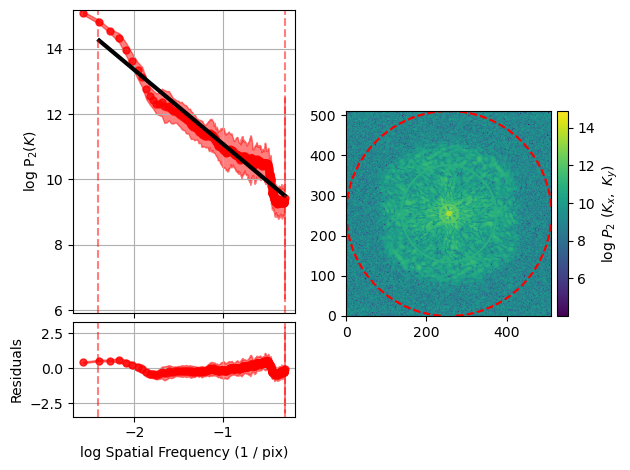

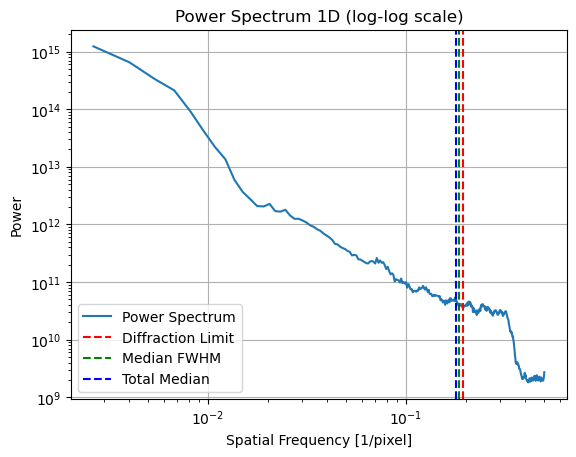

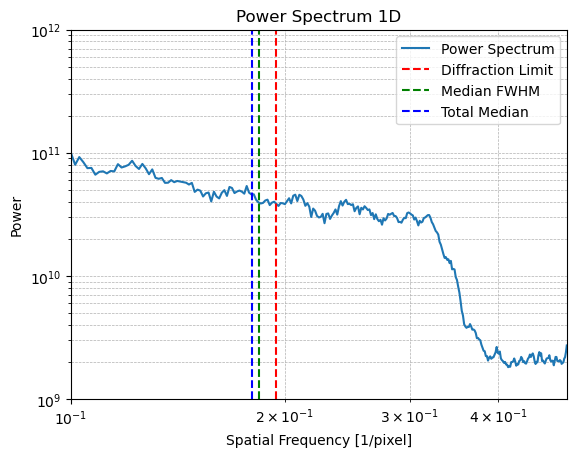

In [ ]:


from astropy.io.fits import Header
from scipy.signal import find_peaks

#################################################################################
imagenumber = 1500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0
image = data.copy()
#############################################################


#SE è DATACUBE ALLORA SI FA image = image [0,:,:] dove il numero selezione l'immagine del cubo
#image = fits.getdata('outputs/composed_fft.fits') #image[0,:,:] #image[0,:,:] #image[imagenumber,:,:] #image[0,:,:]
header = Header()
header['CDELT1'] = 1.0 # scala dei pixel lungo l'asse X (in pixel se si mette la plate scale allora è in arcsec)
header['CDELT2'] = 1.0  # scala dei pixel lungo l'asse Y


# Usa distanza fittizia 
pspec = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec.run(verbose=True, xunit=u.pix**-1)#, low_cut=0.1, high_cut=0.01) 

plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.title('Power Spectrum 1D (log-log scale)')
plt.grid(True)
plt.legend()
plt.show()

plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec.freqs.value.max())
plt.xlim(0.1, pspec.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pspec.freqs.value,
    y=pspec.ps1D,
    mode='lines',
    name='Power Spectrum'
))

fig.update_layout(
    title="Power Spectrum 1D (Interactive)",
    xaxis_title="Frequenza spaziale [1/pixel]",
    yaxis_title="Potenza",
    xaxis_type="log",
    yaxis_type="log",
    template="plotly_white",
    showlegend=True
)
fig.show()


# frequenze = pspec.freqs        # in unità di 1/pixel
# potenza = pspec.ps1D           # spettro radiale
# pendenza = pspec.slope         # pendenza del fit
# print(f"Frequenze: {frequenze}")
# print(f"Potenza: {potenza}")
# print(f"Pendenza: {pendenza}")


## Passband

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


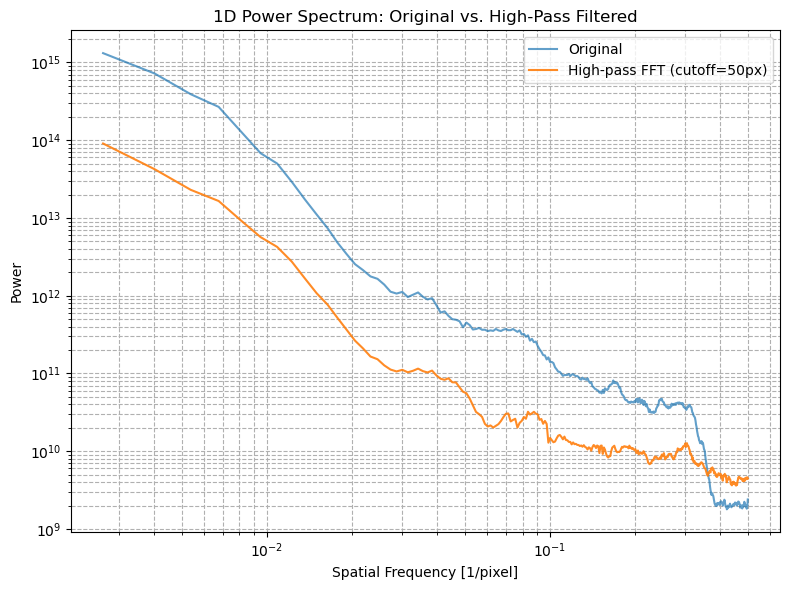

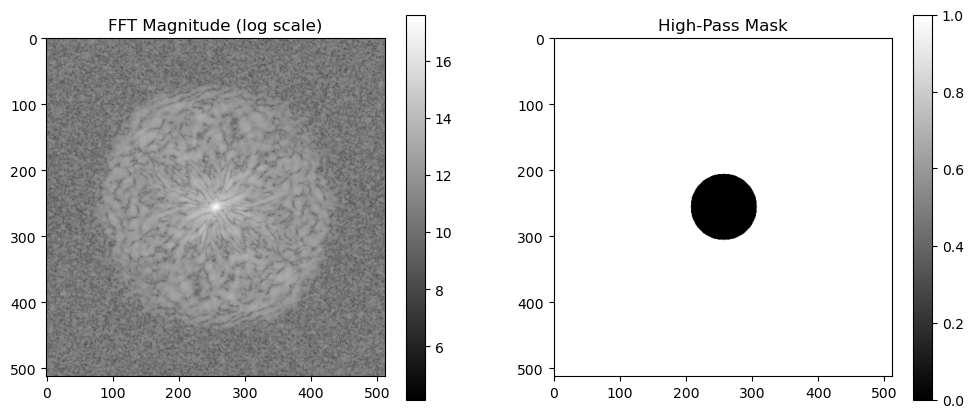

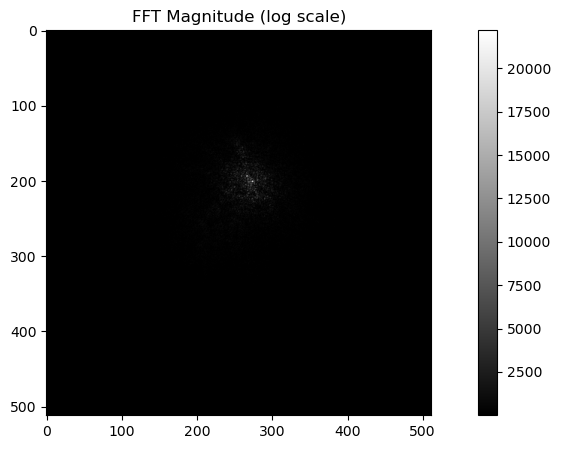

In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
import matplotlib.pyplot as plt


def high_pass_filter_fft(img, cutoff):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    #circular mask
    mask = np.ones((rows, cols), dtype=np.float32)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol)**2 + (y - crow)**2 <= cutoff**2
    mask[mask_area] = 0

    #Apply mask in Fourier space
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    
    return np.abs(img_back), mask

imagenumber = 500
data = immagini[imagenumber]
background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

#High-Pass Filter
cutoff = 50  
highpass, mask = high_pass_filter_fft(image, cutoff=cutoff)

#########################################################################################################
# Power Spectrum 
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

######################### PLOTS #############################
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass FFT (cutoff={cutoff}px)', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [1/pixel]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs. High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

f = np.fft.fftshift(np.fft.fft2(image))
magnitude = np.log(np.abs(f) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(magnitude, cmap='gray')
plt.title("FFT Magnitude (log scale)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("High-Pass Mask")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.imshow(highpass, cmap='gray')
plt.title("FFT Magnitude (log scale)")
plt.colorbar()



## Tentativo 2

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


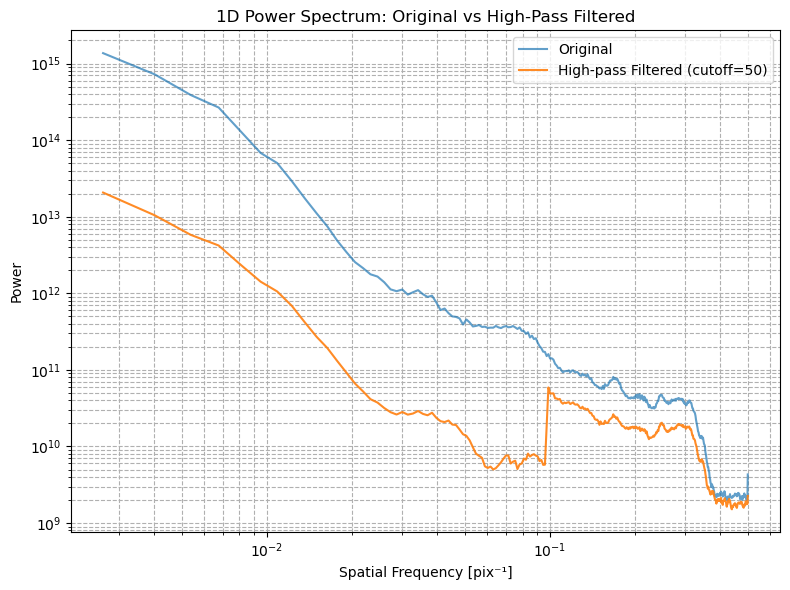

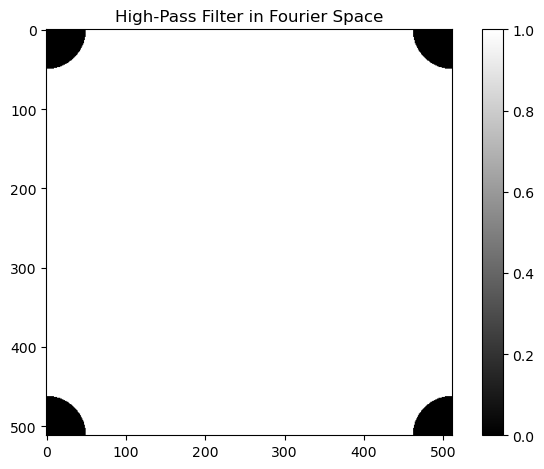

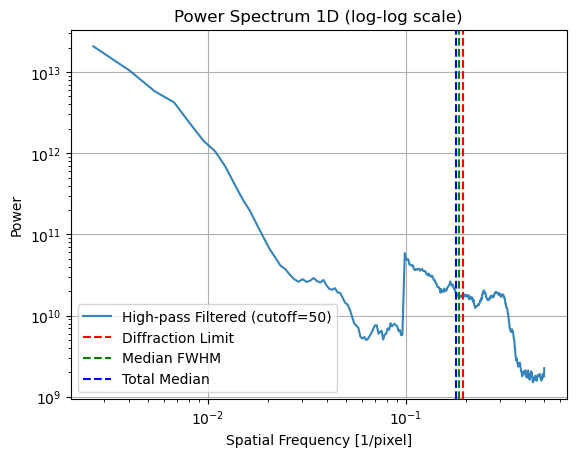

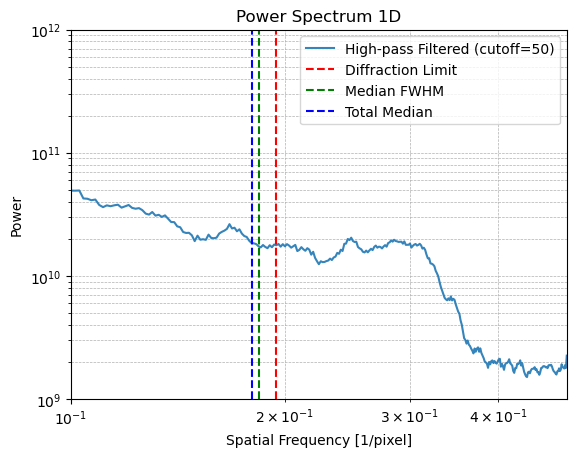

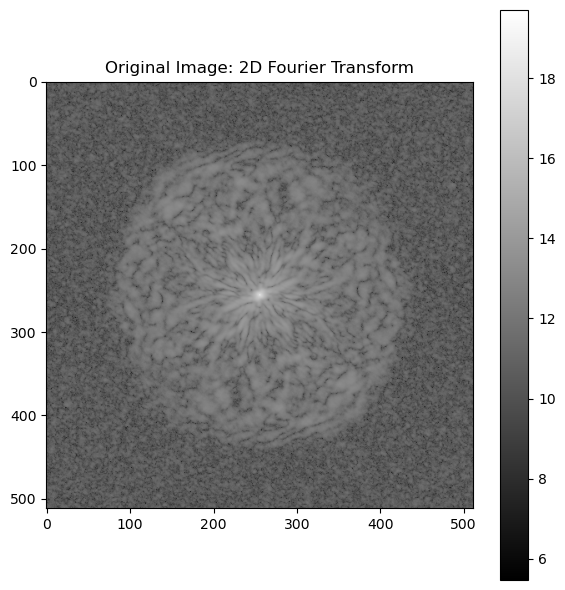

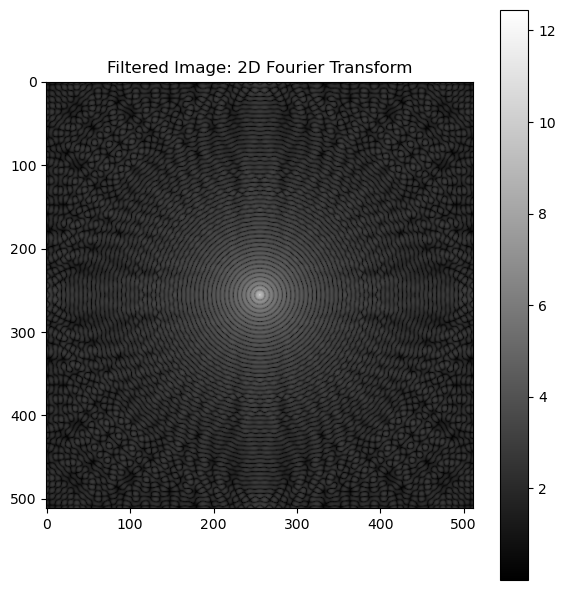

Highpass filtered image saved to outputs/highpass_filtered_image_NOCLEAN.fits


In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from astropy.io import fits
import matplotlib.pyplot as plt

#######################################################################################à
# high-pass filter
def create_highpass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.ones(shape, dtype=np.float32)
    mask[radius_squared < cutoff**2] = 0
    return fftshift(mask)

def create_lowpass_filter(shape, cutoff_low):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.zeros(shape, dtype=np.float32)
    mask[radius_squared < cutoff_low**2] = 1
    return fftshift(mask)

# high-pass filter application
def fourier_highpass_filter(image, cutoff):
    F_image = fft2(image)
    hp_filter = create_highpass_filter(image.shape, cutoff)
    F_filtered = F_image * hp_filter
    filtered_image = ifft2(F_filtered).real
    return filtered_image, hp_filter

# low-pass filter application
def fourier_lowpass_filter(image, cutoff_low):
    F_image = fft2(image)
    lp_filter = create_lowpass_filter(image.shape, cutoff_low)
    F_filtered = F_image * lp_filter
    filtered_image = ifft2(F_filtered).real
    return filtered_image, lp_filter

#####################################################################################################
###############################################################################################à
imagenumber = 500  
stacked = False
if stacked == True:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)  # Sum of  images
    background_level = np.median(data)
    data = data - background_level
    data[data < 0] = 0
    image = data.copy()
else:
    data = immagini[imagenumber]
    #data_raw = data.copy()
    #background_level = np.median(data_raw)
    #data = data_raw - background_level
    #data[data < 0] = 0
    image = data.copy()
#################################################################################################à
# --------------------------------------------
# APPLY FOURIER-SPACE HIGH-PASS FILTER
#image = np.asarray(Image.open('immagini\prova_fft.png'))

cutoff = 50  # Radius in pixels for cutoff frequency
cutoff_low = 200
highpass, hp_filter = fourier_highpass_filter(image, cutoff=cutoff)
lowpass, lp_filter = fourier_lowpass_filter(image, cutoff_low=cutoff_low)

# Check for NaNs or Infs in the filtered image
if np.any(np.isnan(highpass)) or np.any(np.isinf(highpass)):
    print("Warning: NaN or Inf values found in the filtered image!")

# Clip any negative values to zero
highpass = np.maximum(highpass, 0)
lowpass = np.maximum(lowpass, 0)

# Clean filtered images
highpass = np.nan_to_num(highpass)
lowpass = np.nan_to_num(lowpass)

#POWER SPECTRA
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)


#PLOTS
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# FILTER PLOT
plt.figure()
plt.imshow(hp_filter, cmap='gray')
plt.title("High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.title('Power Spectrum 1D (log-log scale)')
plt.grid(True)
plt.legend()
plt.show()

plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec_filtered.freqs.value.max())
plt.xlim(0.1, pspec_filtered.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image) 
    F_image_shifted = fftshift(F_image)  
    magnitude = np.abs(F_image_shifted)  
    
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D Fourier Transform")
plot_fourier_transform(hp_filter, title="Filtered Image: 2D Fourier Transform")
def plot_mask_with_circle(mask, cutoff, title="Mask with Circle"):
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Save the highpass filtered image as a FITS file
output_path = "outputs/highpass_filtered_image_NOCLEAN.fits"
fits.writeto(output_path, highpass, overwrite=True)
print(f"Highpass filtered image saved to {output_path}")



## Gaussian Filter

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


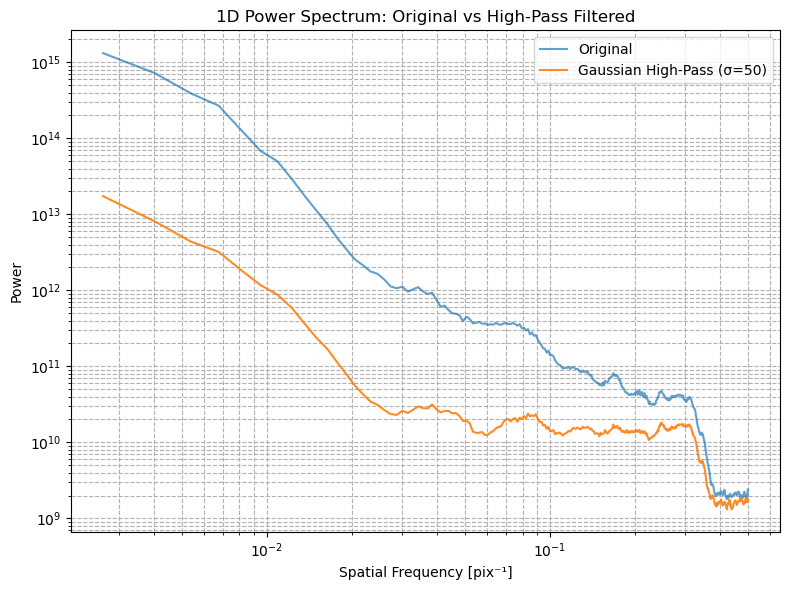

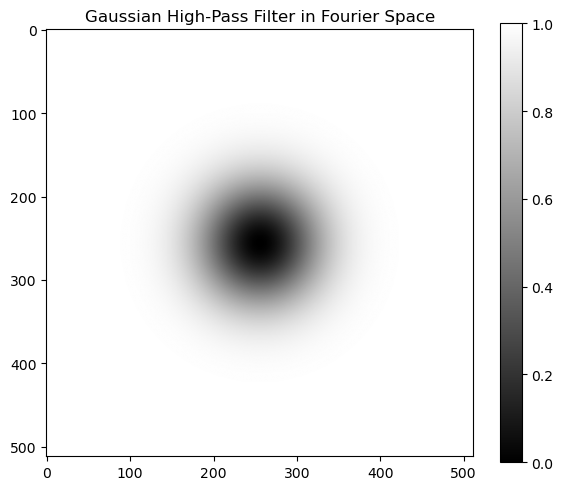

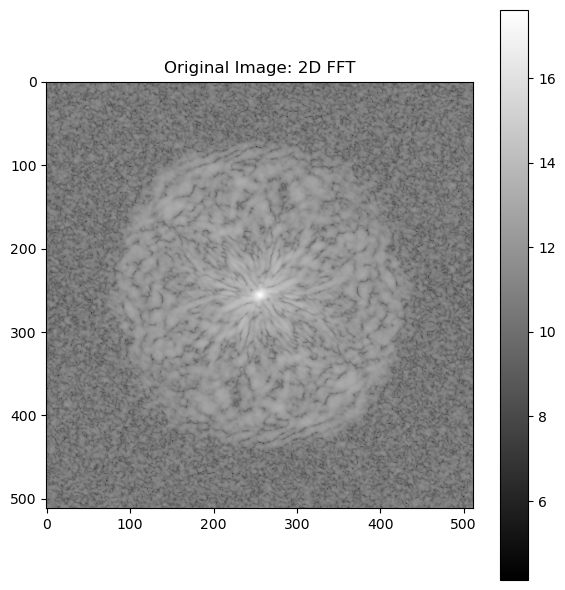

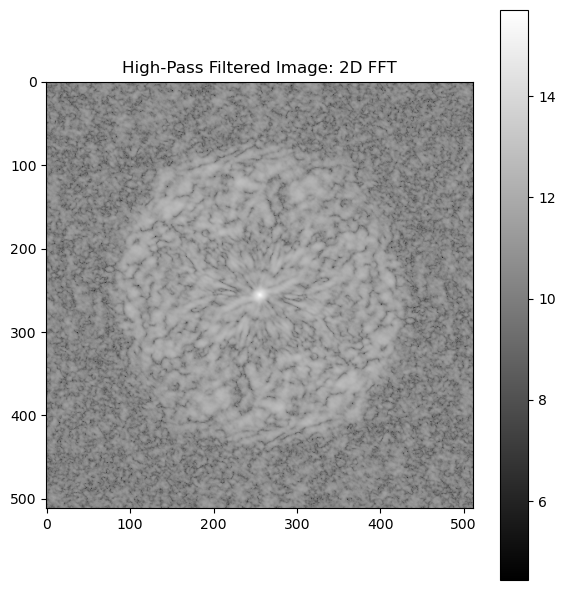

Highpass filtered image saved to outputs/highpass_filtered_image_Gaussian_filter.fits


In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift, fftfreq
import matplotlib.pyplot as plt

# --------------------------------------------
# Gaussian High-Pass Filter (Frequency Domain)
def gaussian_highpass_filter(image, sigma):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    y, x = np.ogrid[:rows, :cols]
    distance_squared = (x - ccol)**2 + (y - crow)**2

    # Create Gaussian low-pass mask, then invert to get high-pass
    gaussian_lp = np.exp(-distance_squared / (2 * sigma**2))
    gaussian_hp = 1 - gaussian_lp

    # Apply in frequency domain
    F_image = fft2(image)
    F_filtered = F_image * fftshift(gaussian_hp)
    filtered_image = np.real(ifft2(F_filtered))

    return filtered_image, gaussian_hp

# --------------------------------------------
# Load and prepare image
imagenumber = 500  
stacked = False  # Set to True to stack images

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# --------------------------------------------
# Apply Gaussian High-Pass Filter
sigma = 50  # Controls frequency cutoff sharpness higher = more tolerant
highpass, hp_filter = gaussian_highpass_filter(image, sigma=sigma)

# Clean filtered image
highpass = np.nan_to_num(np.maximum(highpass, 0))

# --------------------------------------------
# Power Spectrum Calculation
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# --------------------------------------------
# Plot Power Spectra
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'Gaussian High-Pass (σ={sigma})', alpha=0.9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# --------------------------------------------
# Plot Filter
plt.figure(figsize=(6, 5))
plt.imshow(hp_filter, cmap='gray')
plt.title("Gaussian High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

# --------------------------------------------
# Optional: Log-log spectrum with markers (requires external vars)
# Uncomment and define: diffraction_limit_arcseconds, plate_scale
# plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'Filtered (σ={sigma})')
# plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
# plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
# plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
# plt.xlabel('Spatial Frequency [1/pixel]')
# plt.ylabel('Power')
# plt.title('Power Spectrum with Markers')
# plt.grid(True)
# plt.legend()
# plt.show()

# --------------------------------------------
# 2D Fourier Transform Plot
def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image)
    F_image_shifted = fftshift(F_image)
    magnitude = np.abs(F_image_shifted)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D FFT")
plot_fourier_transform(highpass, title="High-Pass Filtered Image: 2D FFT")


# Save the highpass filtered image as a FITS file
output_path = "outputs/highpass_filtered_image_Gaussian_filter.fits"
fits.writeto(output_path, highpass, overwrite=True)
print(f"Highpass filtered image saved to {output_path}")

